# Predict the exchange rate

## Objectives

- Train an ML pipeline using hyperparameter optimization
- Use the best feature to predict exchange rate

## Tasks

- Load data
- Create ML pipeline (use regression model)
- Split the dataset to train and test set
- Grid Search CV - Sklearn

## Input
- Jupyter_notebooks/outputs/dataset/collection/Bitcoin_Price_Data.csv

## Output
- Train set
- Test set
- ML pipeline to predict exchange rate


## Additional information

- This notebook was written based on the guidelines which were provided to "Churnometer" walkthrough project. 

# Change the working directory

## Install Scikit-learn

In [2]:
pip install -U scikit-learn


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Import libraries

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.pipeline import Pipeline

We need to change the working directory from its current folder to its parent folder.

We access the current directory with os.getcwd()

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/fifth-milestone-project-bitcoin/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
- os.path.dirname() gets the parent directory
- os.chdir() defines the new current directory

In [4]:
current_dir = os.getcwd()
os.chdir(os.path.dirname(current_dir))
print()

The command below confirm the new current directory

In [5]:
current_dir = os.getcwd()
current_dir

'/workspace/fifth-milestone-project-bitcoin'

# Load data

Transform the Bitcoin_Price_Data dataset to a pandas data frame.

In [6]:
import pandas as pd
df = pd.read_csv("/workspace/fifth-milestone-project-bitcoin/jupyter_notebooks/outputs/dataset/collection/Bitcoin_Price_Data_int.csv")
df.head()

,Unnamed,ClosingPrice,24hOpen,24hHigh,24hLow
0,0,124,125,125,123
1,1,126,124,126,124
2,2,109,126,126,84
3,3,119,109,119,108
4,4,122,119,122,119


# ML pipeline with regression method

## Create ML pipeline

### Install xgboost

In [7]:
pip install xgboost


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [7]:
from sklearn.pipeline import Pipeline

# Feature Engineering
from feature_engine.encoding import OrdinalEncoder
from feature_engine.selection import SmartCorrelatedSelection
from feature_engine import transformation as vt

# Feature Scaling
from sklearn.preprocessing import StandardScaler

# Feature Selection
from sklearn.feature_selection import SelectFromModel

# ML algorithms
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor

selection_method = "cardinality"
corr_method = "spearman"

def PipelineOptimization(model):
    pipeline_base = Pipeline([
        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['ClosingPrice',
                                                                '24hOpen',
                                                                '24hHigh',
                                                                '24hLow'])),



        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None,
         method=corr_method, threshold=0.6, selection_method=selection_method)),

        ("feat_scaling", StandardScaler()),

        ("feat_selection",  SelectFromModel(model)),

        ("model", model),

    ])

    return pipeline_base

In [8]:
from pandas import MultiIndex, Int64Index

/tmp/ipykernel_779/3793995846.py:1: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


### Hyperparameter optimisation

In [9]:
from sklearn.model_selection import GridSearchCV


class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")

            model = PipelineOptimization(self.models[key])
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring)
            gs.fit(X, y)
            self.grid_searches[key] = gs
        
    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)
        
        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns], self.grid_searches
        

#### Split database to train and test set

In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = (pd.read_csv("/workspace/fifth-milestone-project-bitcoin/jupyter_notebooks/outputs/dataset/collection/Bitcoin_Price_Data_int.csv"))
print(dir(df))
X_train, X_test,y_train, y_test = train_test_split(
                                    df.drop(['ClosingPrice'],axis=1),
                                    df['ClosingPrice'],
                                    test_size = 0.2,
                                    random_state = 0
                                    )

print("* Train set:", X_train.shape, y_train.shape,
      "\n* Test set:",  X_test.shape, y_test.shape)

['ClosingPrice', 'T', 'Unnamed', '_AXIS_LEN', '_AXIS_ORDERS', '_AXIS_TO_AXIS_NUMBER', '_HANDLED_TYPES', '__abs__', '__add__', '__and__', '__annotations__', '__array__', '__array_priority__', '__array_ufunc__', '__array_wrap__', '__bool__', '__class__', '__contains__', '__copy__', '__dataframe__', '__deepcopy__', '__delattr__', '__delitem__', '__dict__', '__dir__', '__divmod__', '__doc__', '__eq__', '__finalize__', '__floordiv__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__getitem__', '__getstate__', '__gt__', '__hash__', '__iadd__', '__iand__', '__ifloordiv__', '__imod__', '__imul__', '__init__', '__init_subclass__', '__invert__', '__ior__', '__ipow__', '__isub__', '__iter__', '__itruediv__', '__ixor__', '__le__', '__len__', '__lt__', '__matmul__', '__mod__', '__module__', '__mul__', '__ne__', '__neg__', '__new__', '__nonzero__', '__or__', '__pos__', '__pow__', '__radd__', '__rand__', '__rdivmod__', '__reduce__', '__reduce_ex__', '__repr__', '__rfloordiv__', '__rmatm

#### Handle target imbalance

In [11]:
pipeline_data_cleaning_feat_eng = PipelineDataCleaningAndFeatureEngineering()
X_train = pipeline_data_cleaning_feat_eng.fit_transform(X_train)
X_test = pipeline_data_cleaning_feat_eng.transform(X_test)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

NameError: name 'PipelineDataCleaningAndFeatureEngineering' is not defined

Train set target distribution checking

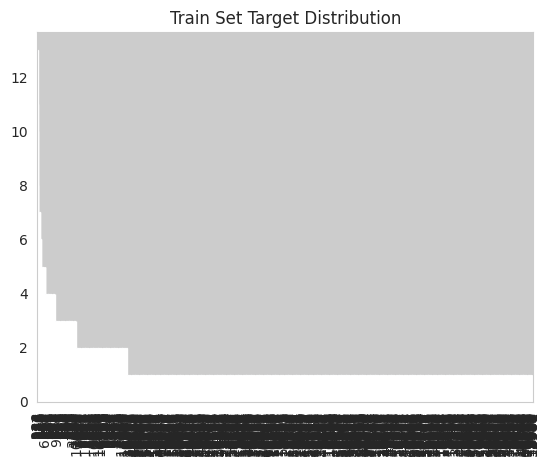

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
y_train.value_counts().plot(kind='bar', title='Train Set Target Distribution')
plt.show()

SMOTE (Synthetic Minority Oversampling TEchnique) using to balance Train set

In [13]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE(sampling_strategy='minority', random_state=0)
X_train, y_train = oversample.fit_resample(X_train, y_train)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

ModuleNotFoundError: No module named 'imblearn'

##### Check Train Set Target distribution after resampling

In [ ]:
import matplotlib.pyplot as plt
y_train.value_counts().plot(kind='bar', title='Train Set Target Distribution')
plt.show()

## Grid CV - Sklearn

Use the default hyperparameter to find a suitable algorythm

In [12]:
models_quick_search = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_quick_search = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}

Optimize the search using default hyperparameter

In [13]:
from sklearn.metrics import make_scorer, recall_score

search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train,
           scoring = make_scorer(recall_score, pos_label=1),
           cv=5, n_jobs=-1)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/pipeline.py", line 401, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/pipeline.py", line 359, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/workspace/.pip-modules/lib/python3.8/site-packages/joblib/memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/pipeline.py", line 893, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/utils/_set_output.py", line 140, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/base.py", line 881, in fit_transform
    return self.fit(X, y, **fit_params).transform(X)
  File "/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/encoding/ordinal.py", line 194, in fit
    self._fit(X)
  File "/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/encoding/base_encoder.py", line 72, in _fit
    self._check_or_select_variables(X)
  File "/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/encoding/base_encoder.py", line 97, in _check_or_select_variables
    ] = _find_or_check_categorical_variables(X, self.variables)
  File "/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/_variable_handling/variable_type_selection.py", line 122, in _find_or_check_categorical_variables
    if len(X[variables].select_dtypes(exclude=["O", "category"]).columns) > 0:
  File "/workspace/.pip-modules/lib/python3.8/site-packages/pandas/core/frame.py", line 3811, in __getitem__
    indexer = self.columns._get_indexer_strict(key, "columns")[1]
  File "/workspace/.pip-modules/lib/python3.8/site-packages/pandas/core/indexes/base.py", line 6113, in _get_indexer_strict
    self._raise_if_missing(keyarr, indexer, axis_name)
  File "/workspace/.pip-modules/lib/python3.8/site-packages/pandas/core/indexes/base.py", line 6176, in _raise_if_missing
    raise KeyError(f"{not_found} not in index")
KeyError: "['ClosingPrice'] not in index"


Check results

In [ ]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

## Extensive search

Extensive search will serve to find in the most suitable model the best hyperparameter configuration. 

In [ ]:
models_search = {
    "RandomForestRegressor":RandomForestRegressor(random_state=0)
}

params_search = {
    "RandomForestRegressor":{
        'model__n_estimators': [,],
        'model__max_depth': [,],
    }
}

Extensive Grid Search CV

In [ ]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)

Check the results

In [ ]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

## Fit in the best model

Define the best model

In [ ]:
best_model = grid_search_summary.iloc[0,0]
best_model

Define the best parameters

In [ ]:
best_parameters = grid_search_pipelines[best_model].best_parameters
best_parameters

Based on search, define the best regressor for project

In [ ]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator
best_regressor_pipeline

## Evaluate pipeline performance

In [15]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error 
import numpy as np

def regression_performance(X_train, y_train, X_test, y_test,pipeline):
	print("Model Evaluation \n")
	print("* Train Set")
	regression_evaluation(X_train,y_train,pipeline)
	print("* Test Set")
	regression_evaluation(X_test,y_test,pipeline)

def regression_evaluation(X,y,pipeline):
  prediction = pipeline.predict(X)
  print('R2 Score:', r2_score(y, prediction).round(3))  
  print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))  
  print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))  
  print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y, prediction)).round(3))
  print("\n")


def regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline, alpha_scatter=0.5):
  pred_train = pipeline.predict(X_train)
  pred_test = pipeline.predict(X_test)


  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
  sns.scatterplot(x=y_train , y=pred_train, alpha=alpha_scatter, ax=axes[0])
  sns.lineplot(x=y_train , y=y_train, color='red', ax=axes[0])
  axes[0].set_xlabel("Actual")
  axes[0].set_ylabel("Predictions")
  axes[0].set_title("Train Set")

  sns.scatterplot(x=y_test , y=pred_test, alpha=alpha_scatter, ax=axes[1])
  sns.lineplot(x=y_test , y=y_test, color='red', ax=axes[1])
  axes[1].set_xlabel("Actual")
  axes[1].set_ylabel("Predictions")
  axes[1].set_title("Test Set")

  plt.show()

In [ ]:
regression_performance(X_train, y_train, X_test, y_test, best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_regressor_pipeline)

## Applying regressor with PCA

In [ ]:
pipeline = PipelineOptimization(model=LinearRegression())
pipeline_pca = Pipeline(pipeline_steps[:6])
df_pca = pipeline_pca.fit_transform(df.drop(['24h High (USD)', '24h Low (USD)'],axis=1))

print(df_pca.shape, '\n', type(df_pca))

In [ ]:
import numpy as np
from sklearn.decomposition import PCA

n_components = 17

def pca_components_analysis(df_pca,n_components): 
    pca = PCA(n_components=n_components).fit(df_pca)
    x_PCA = pca.transform(df_pca) # array with transformed PCA

    ComponentsList = ["Component " + str(number) for number in range(n_components)]
    dfExplVarRatio = pd.DataFrame(
        data= np.round(100 * pca.explained_variance_ratio_ ,3),
        index=ComponentsList,
        columns=['Explained Variance Ratio (%)'])

    dfExplVarRatio['Accumulated Variance'] = dfExplVarRatio['Explained Variance Ratio (%)'].cumsum() 

    PercentageOfDataExplained = dfExplVarRatio['Explained Variance Ratio (%)'].sum()

    print(f"* The {n_components} components explain {round(PercentageOfDataExplained,2)}% of the data \n")
    plt.figure(figsize=(12,5))
    sns.lineplot(data=dfExplVarRatio,  marker="o")
    plt.xticks(rotation=90)
    plt.yticks(np.arange(0, 110, 10))
    plt.show()

pca_components_analysis(df_pca=df_pca,n_components=n_components)

In [ ]:
n_components = 9
pca_components_analysis(df_pca=df_pca,n_components=n_components)

## Rewrite ML pipeline for modelling

In [ ]:
from sklearn.decomposition import PCA

selection_method = "cardinality"
corr_method = "spearman"
n_components = 9

def PipelineOptimization(model):
    pipeline_base = Pipeline([

        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['Closing Price (USD)',
                                                                '24h Open (USD)',
                                                                '24h High (USD)',
                                                                '24h Low (USD)'])),



        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None,
         method=corr_method, threshold=0.6, selection_method=selection_method)),

        ("feat_scaling", StandardScaler()),

        ("feat_selection",  SelectFromModel(model)),

        ("model", model),

    ])

    return pipeline_base

GridSearch CV

In [ ]:
print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",  X_test.shape, y_test.shape)

Standard hyperparameter using to find the most suitable model for project

In [ ]:
models_quick_search = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_quick_search = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}

Quick optimization

In [ ]:
quick_search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
quick_search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)

Check the results

In [ ]:
grid_search_summary, grid_search_pipelines = quick_search.score_summary(sort_by='mean_score')
grid_search_summary

Extensive search for hyperparameter configuration

In [ ]:
models_search = {
    "RandomForestRegressor":RandomForestRegressor(random_state=0),
}

params_search = {
    "RandomForestRegressor":{
        'model__n_estimators': [,],
        'model__max_depth': [,,],
    }
}

Extensive GridSearch CV

In [ ]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)

Check results

In [ ]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

Check best model

In [ ]:
best_model = grid_search_summary.iloc[0,0]
best_model

Parameters of best model

In [ ]:
grid_search_pipelines[best_model].best_parameters

Define regressor model

In [ ]:
best_regressor_pipeline_pca = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline_pca

Evaluating regressor on the train and test set

In [ ]:
regression_performance(X_train, y_train, X_test, y_test,best_regressor_pipeline_pca)
regression_evaluation_plots(X_train, y_train, X_test, y_test,
                            best_regressor_pipeline_pca)

Subset best features

In [ ]:
X_train = X_train.filter(best_features)
X_test = X_test.filter(best_features)

print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:", X_test.shape, y_test.shape)
X_train.head()

Refit the pipeline

In [ ]:
def PipelineOptimization(model):
    pipeline_base = Pipeline([

      ("NumericLogTransform", vt.LogTransformer(variables=['Closing Price (USD)',
                                                           '24h Open (USD)'])),

      ("feat_scaling", StandardScaler()),

      ("model", model),

    ])

    return pipeline_base

Manually provided values

In [ ]:
parameters_search = {
    'RandomForestRegressor':  {
        'model__max_depth': [],
        'model__n_estimators': []
        }
    }
parameters_search

GridSearch CV

In [ ]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)

Check results

In [ ]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

Check best model

In [ ]:
best_model = grid_search_summary.iloc[0,0]
best_model

Check best regressor pipeline

In [ ]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

Performance of train and test set

In [ ]:
regression_performance(X_train, y_train, X_test, y_test, best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_regressor_pipeline)

## Save dataset and models

In [ ]:
import os

version = 'final'
file_path = f'outputs/dataset/collection/{version}'

try:
  os.makedirs(name=file_path)
except Exception as e:
  print(e)

### Train set saving

In [ ]:
print(X_train.shape)
X_train.head()

In [ ]:
X_train.to_csv(f"{file_path}/X_train.csv", index=False)

In [ ]:
print(y_train.shape)
y_train.head()

In [ ]:
y_train.to_csv(f"{file_path}/y_train.csv", index=False)

### Test set saving

In [ ]:
print(X_test.shape)
X_test.head()

In [ ]:
X_test.to_csv(f"{file_path}/X_test.csv", index=False)

In [ ]:
print(y_test.shape)
y_test.head()

In [ ]:
y_test.to_csv(f"{file_path}/y_test.csv", index=False)

Modelling pipeline

In [ ]:
import joblib
joblib.dump(value=best_regressor_pipeline, filename=f"{file_path}/best_regressor_pipeline.pkl")